In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline
RANDOM_SEED = 34791

# Loading data

In [2]:
X_data = pd.read_csv('data/train_data.csv')
X_data_ktest = pd.read_csv('data/test_data.csv')
y_data = pd.read_csv('data/train_target.csv', header=-1, names=['agreed'])

In [3]:
print('Is everything ok?: ',  X_data.shape[0] == y_data.shape[0])
print('And duplicates?: ',  np.all(X_data.duplicated() == False))

Is everything ok?:  True
And duplicates?:  False


Checking if balanced sample:


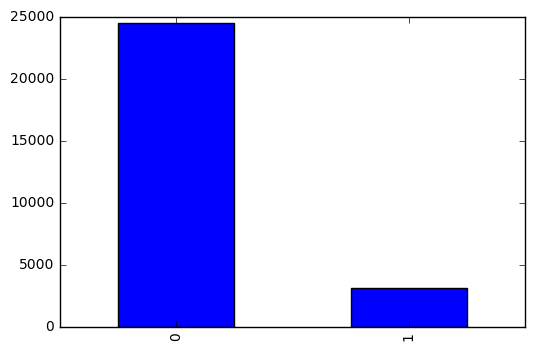

In [4]:
print('Checking if balanced sample:')
y_data['agreed'].value_counts().plot(kind='bar');

# Working with features

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
X_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.00000
mean,40.085994,258.874542,2.568328,962.693169,0.172024,0.087211,93.577443,-40.503026,3.628844,5167.31696
std,10.480548,260.511236,2.765561,186.371948,0.492548,1.567343,0.578193,4.616641,1.730084,72.22960
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.60000
25%,32.000000,101.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.10000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.00000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.10000
max,94.000000,4199.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.10000


In [7]:
def convert_features(data):
    conv_data = data.copy()
    
    conv_data['default'] = conv_data.apply(lambda row: 1 if row['default'] == 'yes' else 0, axis=1)
    
    conv_data['housing'] = conv_data.apply(lambda row: 1 if row['housing'] == 'yes' else 0, axis=1)
    
    conv_data['loan'] = conv_data.apply(lambda row: 1 if row['loan'] == 'yes' else 0, axis=1)
    
    
    # nominal values
    nom_df = conv_data[['poutcome', 'contact', 'month', 'day_of_week', 'education', 'marital', 'job']]
    conv_data = conv_data.drop(nom_df.columns, axis=1)
    nom_df = pd.get_dummies(nom_df)
    conv_data = pd.concat([conv_data, nom_df], axis = 1)
    
    
    colls_to_scale = ['age','campaign', 'pdays', 
                                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    
    df_to_scale = conv_data[colls_to_scale]
    
    conv_data = conv_data.drop(colls_to_scale, axis = 1)
    scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(df_to_scale))
    scaled_data.columns = colls_to_scale
    
    conv_data = pd.concat([conv_data, scaled_data], axis = 1)
    
    # drop unused
    conv_data = conv_data.drop(['previous'], axis = 1)
    
    return conv_data

In [8]:
X_data = convert_features(X_data)

# Undersampling major feature

In [9]:
from imblearn.under_sampling import RandomUnderSampler

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
X_cols = X_data.columns
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_data, y_data = rus.fit_sample(X_data, y_data['agreed'].values.ravel())

In [11]:
X_data = pd.DataFrame(X_data)
X_data.columns = X_cols
y_data = pd.DataFrame(y_data)
y_data.columns = ['agreed']

In [12]:
X_data.shape

(6228, 56)

# And updating test sample

In [13]:
X_data_ktest = convert_features(X_data_ktest)

# Plot with all features

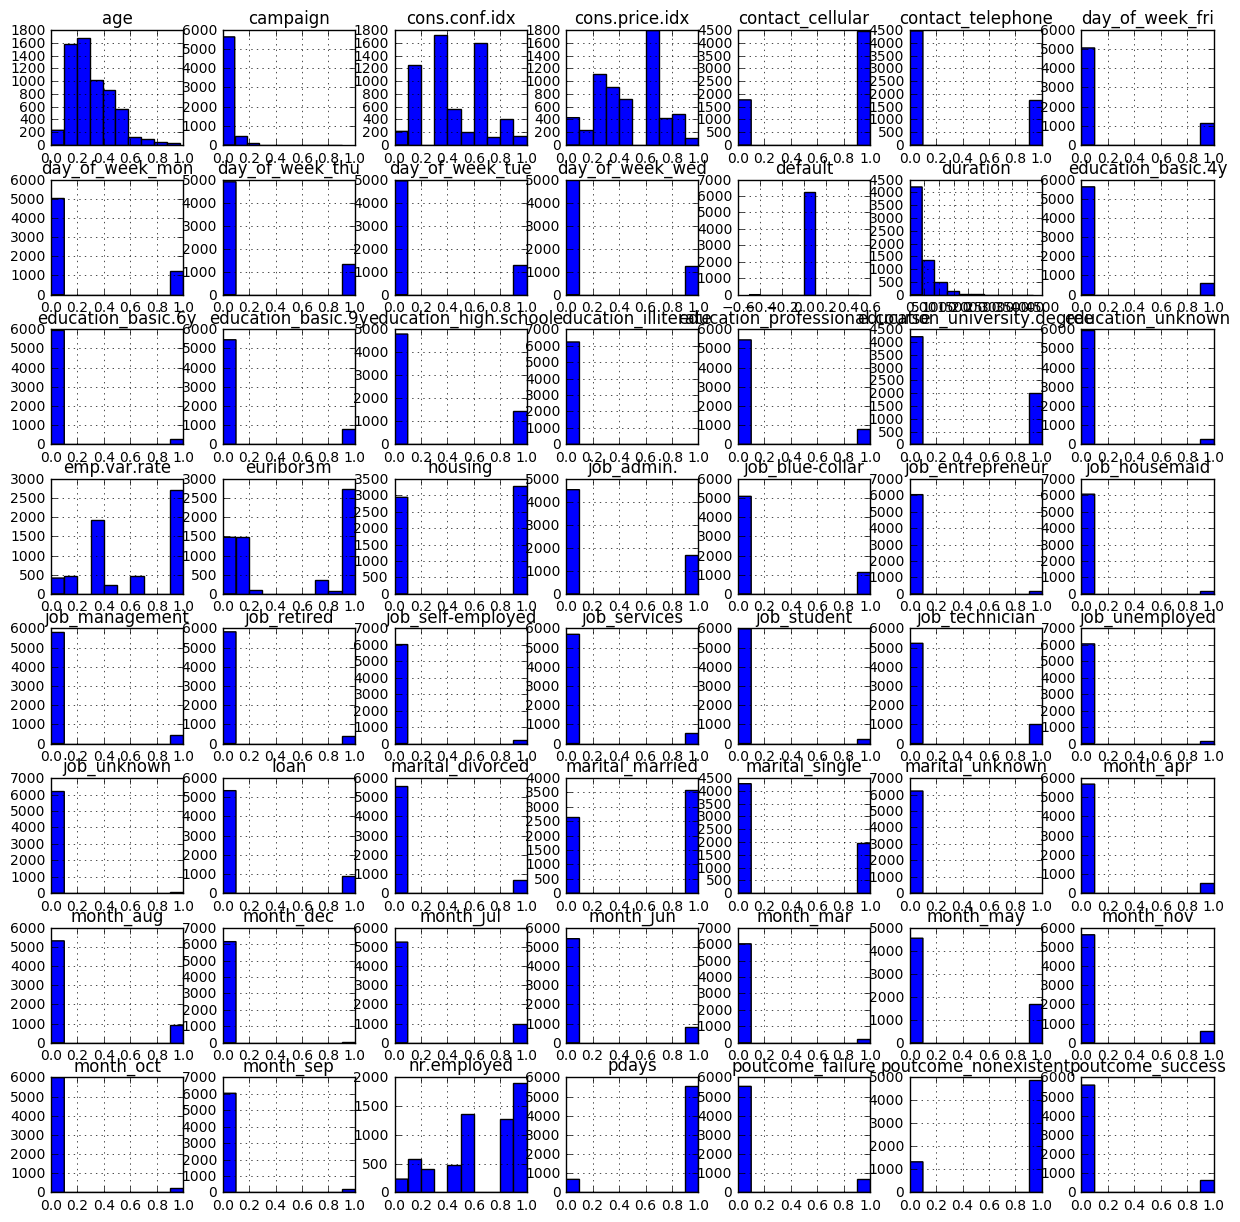

In [14]:
X_data.hist(figsize=(15, 15));

# Splitting data into train/test sets

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data['agreed'].values, test_size=0.25, 
                 random_state = RANDOM_SEED, stratify=y_data['agreed'].values)

# Fitting models

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [18]:
def top_importance_print(n, importances, importances_names):
    indexes = importances.argsort()[-n:][::-1]
    for i, index in enumerate(indexes):
        print ('#{} Important feature is -- {} with {:.2f} importance'.format(i + 1, importances_names[index], importances[index]))

In [19]:
def write_to_submission_file(predicted_labels, out_file='output.csv',
                             target='Prediction', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [20]:
class ModelTester():
    def __init__(self, parameters, model, scoring='roc_auc', njobs=-1, cv=3):
        self.cv = GridSearchCV(model, parameters, scoring = scoring, n_jobs = njobs, cv = cv, verbose = 1)
    
    def test_model(self):
        self.cv.fit(X_train, y_train);
        print('Best score cv: ', self.cv.best_score_)
        print('Params: ', self.cv.best_params_)
    
        y_predicted = self.cv.predict(X_test)
        print('Score on test sample:', roc_auc_score(y_test, y_predicted))
        
    def best_estimator(self):
        return self.cv.best_estimator_
    

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced', None]}

mt = ModelTester(parameters = param, model = RandomForestClassifier(random_state=RANDOM_SEED))
mt.test_model()
rf_clf = mt.best_estimator()

Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.9s


Best score cv:  0.932418047234
Params:  {'max_features': 'auto', 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 16}
Score on test sample: 0.884411990852


[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   12.0s finished


## SVC

In [23]:
from sklearn.svm import SVC

In [24]:
param = {'C': np.linspace(0.01, 0.03, num=5), 
              'class_weight':['balanced', None], 'kernel':['linear'],
              'decision_function_shape' : ['ovo', 'ovr', None]}

mt = ModelTester(parameters = param, model = SVC(random_state=RANDOM_SEED))
mt.test_model()
svc_clf = mt.best_estimator()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.4min finished


Best score cv:  0.934416636487
Params:  {'decision_function_shape': 'ovo', 'class_weight': 'balanced', 'kernel': 'linear', 'C': 0.029999999999999999}
Score on test sample: 0.882488920275


## AdaBoostClassifier

In [25]:
from sklearn.ensemble import AdaBoostClassifier

In [26]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}

mt = ModelTester(parameters = param, model = AdaBoostClassifier(random_state=RANDOM_SEED))
mt.test_model()
adc_clf = mt.best_estimator()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s finished


Best score cv:  0.936393777203
Params:  {'learning_rate': 0.3, 'algorithm': 'SAMME.R'}
Score on test sample: 0.883112618841


## DecisionTreeClassifier

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RANDOM_SEED], 'presort':[True, False]}

mt = ModelTester(parameters = param, model = DecisionTreeClassifier(random_state=RANDOM_SEED))
mt.test_model()
dtc_clf = mt.best_estimator()

Fitting 3 folds for each of 56 candidates, totalling 168 fits
Best score cv:  0.827875329573
Params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'splitter': 'best', 'max_features': 'auto', 'random_state': 34791, 'presort': True}
Score on test sample: 0.824013879768


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.1s finished


# KNeighborsClassifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
param = {'n_neighbors': [30, 50, 70], 'weights': ['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'leaf_size' : [20, 30, 50], 'p':[1, 2]}

mt = ModelTester(parameters = param, model = KNeighborsClassifier())
mt.test_model()
knn_clf = mt.best_estimator()

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.4s


Best score cv:  0.901915646724
Params:  {'weights': 'distance', 'p': 1, 'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 30}
Score on test sample: 0.865771158726


[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.3min finished


# GradientBoostingClassifier

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
param = {'loss': ['deviance', 'exponential'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 'presort':[True, False],
         'n_estimators':[200, 300], 'min_samples_leaf' : [3]}

mt = ModelTester(parameters = param, model = GradientBoostingClassifier(random_state=RANDOM_SEED))
mt.test_model()
gbc_clf = mt.best_estimator()

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   49.5s finished


Best score cv:  0.945433267989
Params:  {'max_features': 4, 'min_samples_leaf': 3, 'loss': 'deviance', 'n_estimators': 300, 'presort': True}
Score on test sample: 0.892116648132


# XGBoost

In [33]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import math

In [34]:
param = {'max_depth': range(2, 10), 'n_estimators': [2, 4, 5, 6, 25, 35, 50, 150], 'objective' : 
         ['reg:linear', 'binary:logistic', 'binary:logitraw', 'rank:pairwise'],
        'learning_rate' : [0.075]}

mt = ModelTester(parameters = param, model = XGBClassifier(seed=RANDOM_SEED, reg_alpha=0.005, reg_lambda=0.004))
mt.test_model()
xgb_clf = mt.best_estimator()

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  1.8min finished


Best score cv:  0.94838779655
Params:  {'max_depth': 5, 'learning_rate': 0.075, 'objective': 'rank:pairwise', 'n_estimators': 150}
Score on test sample: 0.892124073115


# VotingClassifier

In [38]:
from sklearn.ensemble import VotingClassifier

In [39]:
eclf = VotingClassifier(estimators=[('rf', rf_clf), ('knn', knn_clf)], voting='soft')
eclf.fit(X_train, y_train);

In [40]:
y_predicted = eclf.predict(X_test)
print('Score on full sample:', roc_auc_score(y_test, y_predicted))

Score on full sample: 0.894043843699


In [41]:
y_predicted = eclf.predict_proba(X_data_ktest)
write_to_submission_file(y_predicted[:, 1])